In [3]:
import os
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys; sys.path.insert(0, "../utils/")
from data_utils import get_data_location, get_clinical_df, get_bluepoints_df, get_manual_severity_scores
from ml_pipeline import ModelEvaluation, highlight_max

DATA_PATH = get_data_location()

In [4]:
DIAGRAMS_PATH = os.path.join(DATA_PATH,"cropped_videos_segmented/persistence_diagrams")

# List all files & directories
diagrams_files = os.listdir(DIAGRAMS_PATH)

# keep only files that end with .npy
diagrams_files = [x for x in diagrams_files if x.endswith(".npy")]

len(diagrams_files)

369

In [5]:
# Load the first file
diagrams = np.load(os.path.join(DIAGRAMS_PATH, diagrams_files[0]), allow_pickle=True)
diagrams.shape

(4, 9439, 3)

In [6]:
from gtda.plotting import plot_diagram
# plot_diagram(diagrams[0])

In [7]:
from gtda.diagrams import PersistenceEntropy

persistence_entropy = PersistenceEntropy()

# calculate topological feature matrix
X_basic = persistence_entropy.fit_transform(diagrams)

# expect shape - (n_point_clouds, n_homology_dims)
print(X_basic.shape)

# flatten the matrix to get one feature vector per video
X_basic = X_basic.flatten()
X_basic.shape

(4, 3)


(12,)

In [8]:
import pandas as pd

# Create a dataframe from digrams_files
df = pd.DataFrame(diagrams_files, columns=["file_name"])

# Split the file name to get the patient id
df["Patient ID"] = df["file_name"].apply(lambda x: x.split("_")[1])
# Split the file name to get the video name
df["video_name"] = df["file_name"].apply(lambda x: x.split("_")[2] + "_" + x.split("_")[3])
# Load the diagrams into the dataframe
df["diagrams"] = df["file_name"].apply(lambda x: np.load(os.path.join(DIAGRAMS_PATH, x), allow_pickle=True))

df.head()

,file_name,Patient ID,video_name,diagrams
0,diagrams_A001_image_147606973438168_processed_...,A001,image_147606973438168,"[[[0.0, 0.011129842139780521, 0.0], [0.0, 0.01..."
1,diagrams_A001_image_147549867609700_processed_...,A001,image_147549867609700,"[[[0.0, 0.014365816488862038, 0.0], [0.0, 0.01..."
2,diagrams_A001_image_147690538547824_processed_...,A001,image_147690538547824,"[[[0.0, 0.013820723630487919, 0.0], [0.0, 0.01..."
3,diagrams_A001_image_147857626821302_processed_...,A001,image_147857626821302,"[[[0.0, 0.015802821144461632, 0.0], [0.0, 0.01..."
4,diagrams_A001_image_147814256633037_processed_...,A001,image_147814256633037,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."


In [9]:
clinical_data = get_clinical_df()

clinical_data = clinical_data[["Video ID", "clin_diagn#COVID19_pneumonia"]]
clinical_data.columns = ["Patient ID", "COVID19"]
df = pd.merge(df, clinical_data, on="Patient ID", how="left")

bp = get_bluepoints_df()
df = pd.merge(df, bp[["Bluepoint", "video_name"]], on="video_name", how="left")

df.head(1)

,file_name,Patient ID,video_name,diagrams,COVID19,Bluepoint
0,diagrams_A001_image_147606973438168_processed_...,A001,image_147606973438168,"[[[0.0, 0.011129842139780521, 0.0], [0.0, 0.01...",0,R2


In [10]:
def featurize_diagram(diagram, representation):
    """Featurize diagrams with a given representation.
    
    Parameters
    ----------
    diagram : ndarray
        A persistence diagram in the gtda format.
    representation : object
        A representation object from gtda.diagrams.
        
    Returns
    -------
    X : ndarray
        A feature vector.
    """
    return representation.fit_transform(diagram).flatten()


In [11]:
# Import different featurizers
from gtda.diagrams import PersistenceEntropy
from gtda.diagrams import Amplitude
from gtda.diagrams import BettiCurve
from gtda.diagrams import PersistenceImage
from gtda.diagrams import NumberOfPoints

# Store all featurizer in a dict with name as key
featurizers = {"Persistence Entropy" : PersistenceEntropy(),
                "Number of Points" : NumberOfPoints(),
                "Wasserstein Amplitude" : Amplitude(metric='wasserstein'),
                "Bottleneck Amplitude" : Amplitude(metric='bottleneck'),
                "Landscape Amplitude" : Amplitude(metric='landscape'),
                "Betti Curves" : BettiCurve(n_bins=20),
                "Persistence Image" : PersistenceImage(n_bins=10, n_jobs=-1), 
                
                }

# Apply the different featurizers to the diagrams and add them to the dataframe in separate columns
for name, featurizer in featurizers.items():
    print(f"Calculating {name}")
    df[name] = df["diagrams"].apply(lambda x: featurize_diagram(x, featurizer))
df.head(1)

Calculating Persistence Entropy
Calculating Number of Points
Calculating Wasserstein Amplitude
Calculating Bottleneck Amplitude
Calculating Landscape Amplitude
Calculating Betti Curves
Calculating Persistence Image


,file_name,Patient ID,video_name,diagrams,COVID19,Bluepoint,Persistence Entropy,Number of Points,Wasserstein Amplitude,Bottleneck Amplitude,Landscape Amplitude,Betti Curves,Persistence Image
0,diagrams_A001_image_147606973438168_processed_...,A001,image_147606973438168,"[[[0.0, 0.011129842139780521, 0.0], [0.0, 0.01...",0,R2,"[9.84487277087777, 9.488478721971166, 4.492168...","[1038, 772, 39, 1151, 970, 51, 4478, 4742, 219...","[0.2821155785865827, 0.06714671157959838, 0.02...","[0.118050217628479, 0.004073821008205414, 0.01...","[0.033120796982921336, 0.00028673226566222897,...","[1038, 6, 6, 6, 6, 4, 4, 4, 3, 3, 3, 1, 1, 0, ...","[40.423103856339345, 36.07662596770036, 25.645..."


## Train models

In [12]:
Classifier = ModelEvaluation("classification")

In [13]:
featurizer_models = pd.DataFrame()
featurizer_models_all = pd.DataFrame()
for name, featurizer in featurizers.items():
    print(f"Training model for {name}...")
    X = np.stack(df[name].values)
    y = df["COVID19"].values
    groups = df["Patient ID"].values
    
    scores, scores_mean = Classifier.train_models(X, y, groups=groups, plot=False)
    scores = pd.concat([scores], keys=[name], names=['Featurizer'])
    scores_mean = pd.concat([scores_mean], keys=[name], names=['Featurizer'])
    
    featurizer_models_all = pd.concat([featurizer_models_all, scores])
    featurizer_models = pd.concat([featurizer_models, scores_mean])
    
featurizer_models.groupby("Featurizer").mean().sort_values(by=["test_accuracy", "test_f1"], ascending=False).style.apply(highlight_max).format("{:.2f}")

Training model for Persistence Entropy...
Training model for Number of Points...
Training model for Wasserstein Amplitude...
Training model for Bottleneck Amplitude...
Training model for Landscape Amplitude...
Training model for Betti Curves...


/scratch_net/gnarf/mrichte/conda_envs/tda/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training model for Persistence Image...


/scratch_net/gnarf/mrichte/conda_envs/tda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch_net/gnarf/mrichte/conda_envs/tda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

,test_accuracy,test_sensitivity,test_specificity,test_f1
Featurizer,,,,
Number of Points,0.66,0.74,0.61,0.69
Persistence Entropy,0.63,0.71,0.59,0.66
Wasserstein Amplitude,0.61,0.72,0.52,0.65
Persistence Image,0.61,0.67,0.58,0.63
Bottleneck Amplitude,0.60,0.69,0.56,0.64
Betti Curves,0.59,0.69,0.51,0.63
Landscape Amplitude,0.59,0.65,0.59,0.61


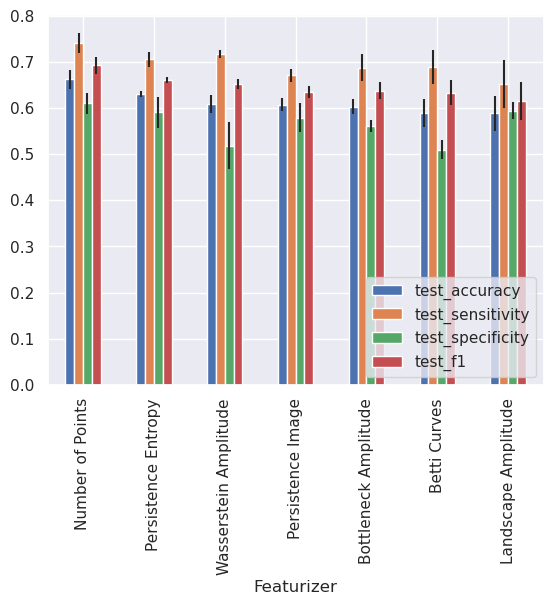

In [14]:
featurizer_models.groupby("Featurizer").mean().sort_values(by=["test_accuracy", "test_f1"], ascending=False).plot.bar(yerr=featurizer_models.groupby("Featurizer").std())
plt.legend(loc='lower right')

,test_accuracy,test_sensitivity,test_specificity,test_f1
Number of Points (LR),0.67,0.76,0.61,0.70
Persistence Entropy (LR),0.64,0.71,0.61,0.66
Landscape Amplitude (RF),0.63,0.71,0.57,0.66
Wasserstein Amplitude (RF),0.63,0.71,0.58,0.66
Bottleneck Amplitude (RF),0.62,0.72,0.55,0.66
Betti Curves (RF),0.62,0.73,0.52,0.66
Persistence Image (RF),0.62,0.68,0.61,0.64


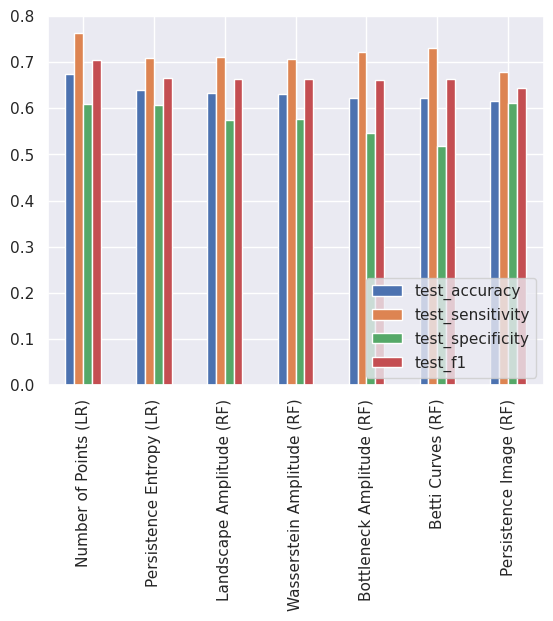

In [15]:
grouped = featurizer_models.groupby("Featurizer")
max_index = grouped["test_accuracy"].idxmax()
best_models = featurizer_models.loc[max_index].sort_values("test_accuracy", ascending=False)
best_models.index = best_models.reset_index().Featurizer + " (" + best_models.reset_index().model + ")"

best_models.plot.bar()
plt.legend(loc='lower right')

best_models.style.apply(highlight_max).format("{:.2f}")

In [16]:
print(best_models.to_latex(float_format="{:.2f}".format))

\begin{tabular}{lrrrr}
\toprule
{} &  test\_accuracy &  test\_sensitivity &  test\_specificity &  test\_f1 \\
\midrule
Number of Points (LR)      &           0.67 &              0.76 &              0.61 &     0.70 \\
Persistence Entropy (LR)   &           0.64 &              0.71 &              0.61 &     0.66 \\
Landscape Amplitude (RF)   &           0.63 &              0.71 &              0.57 &     0.66 \\
Wasserstein Amplitude (RF) &           0.63 &              0.71 &              0.58 &     0.66 \\
Bottleneck Amplitude (RF)  &           0.62 &              0.72 &              0.55 &     0.66 \\
Betti Curves (RF)          &           0.62 &              0.73 &              0.52 &     0.66 \\
Persistence Image (RF)     &           0.62 &              0.68 &              0.61 &     0.64 \\
\bottomrule
\end{tabular}



# Patient Level


In [17]:
# Aggregate feature vectors across each Patient using the mean
patient_level_df = df.groupby("Patient ID")[list(featurizers.keys())].mean().reset_index()
# Add back Covid variable
patient_level_df = pd.merge(df.groupby("Patient ID")["COVID19"].first().reset_index(), patient_level_df)
patient_level_df.head(1)

,Patient ID,COVID19,Persistence Entropy,Number of Points,Wasserstein Amplitude,Bottleneck Amplitude,Landscape Amplitude,Betti Curves,Persistence Image
0,A001,0,"[6.365909203072956, 6.147308222939114, 2.80300...","[951.6666666666666, 725.5, 38.166666666666664,...","[0.2601690022237462, 0.059145498818450104, 0.0...","[0.13479669019579887, 0.005395637825131416, 0....","[0.06188385944692565, 0.0005106886219982841, 0...","[951.6666666666666, 2.8333333333333335, 2.0, 1...","[9.393933315759865, 8.529169547680075, 6.41277..."


In [18]:
featurizer_models_patients = pd.DataFrame()
featurizer_models_all_patients = pd.DataFrame()
for name, featurizer in featurizers.items():
    print(f"Training model for {name}...")
    X = np.stack(patient_level_df[name].values)
    y = patient_level_df["COVID19"].values
    
    scores, scores_mean = Classifier.train_models(X, y, plot=False)
    scores = pd.concat([scores], keys=[name], names=['Featurizer'])
    scores_mean = pd.concat([scores_mean], keys=[name], names=['Featurizer'])
    
    featurizer_models_all_patients = pd.concat([featurizer_models_all_patients, scores])
    featurizer_models_patients = pd.concat([featurizer_models_patients, scores_mean])
    
#featurizer_models.style.apply(highlight_max).format("{:.2f}")

Training model for Persistence Entropy...
Training model for Number of Points...
Training model for Wasserstein Amplitude...
Training model for Bottleneck Amplitude...
Training model for Landscape Amplitude...
Training model for Betti Curves...
Training model for Persistence Image...


/scratch_net/gnarf/mrichte/conda_envs/tda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch_net/gnarf/mrichte/conda_envs/tda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

,test_accuracy,test_sensitivity,test_specificity,test_f1
Number of Points (SVM),0.76,0.79,0.73,0.78
Persistence Entropy (SVM),0.71,0.73,0.70,0.72
Persistence Image (RF),0.70,0.72,0.67,0.70
Betti Curves (RF),0.68,0.75,0.60,0.70
Landscape Amplitude (LR),0.68,0.69,0.67,0.69
Wasserstein Amplitude (LR),0.65,0.67,0.63,0.68
Bottleneck Amplitude (RF),0.64,0.70,0.57,0.67


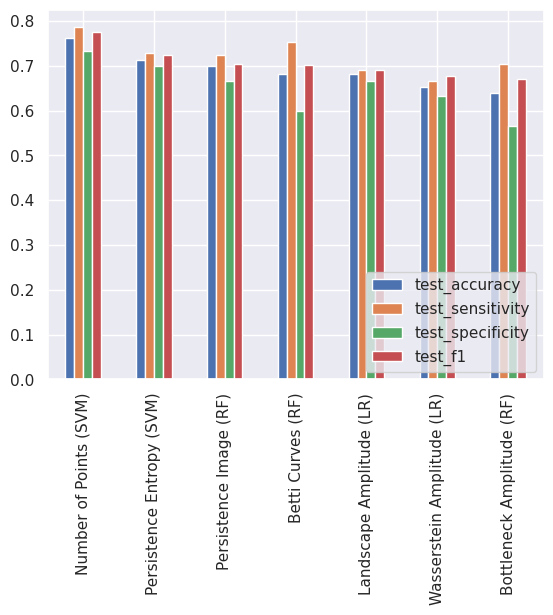

In [19]:
grouped = featurizer_models_patients.groupby("Featurizer")
max_index = grouped["test_accuracy"].idxmax()
best_models = featurizer_models_patients.loc[max_index].sort_values("test_accuracy", ascending=False)
best_models.index = best_models.reset_index().Featurizer + " (" + best_models.reset_index().model + ")"

best_models.plot.bar()
plt.legend(loc='lower right')

best_models.style.apply(highlight_max).format("{:.2f}")

In [20]:
print(best_models.to_latex(float_format="{:.2f}".format))

\begin{tabular}{lrrrr}
\toprule
{} &  test\_accuracy &  test\_sensitivity &  test\_specificity &  test\_f1 \\
\midrule
Number of Points (SVM)     &           0.76 &              0.79 &              0.73 &     0.78 \\
Persistence Entropy (SVM)  &           0.71 &              0.73 &              0.70 &     0.72 \\
Persistence Image (RF)     &           0.70 &              0.72 &              0.67 &     0.70 \\
Betti Curves (RF)          &           0.68 &              0.75 &              0.60 &     0.70 \\
Landscape Amplitude (LR)   &           0.68 &              0.69 &              0.67 &     0.69 \\
Wasserstein Amplitude (LR) &           0.65 &              0.67 &              0.63 &     0.68 \\
Bottleneck Amplitude (RF)  &           0.64 &              0.70 &              0.57 &     0.67 \\
\bottomrule
\end{tabular}



# Severity Scores

In [21]:
sev_scores = get_manual_severity_scores()
sev_scores = sev_scores[["Severity Score", "video_name"]]
sev_scores["Severity Score"] = sev_scores["Severity Score"].astype(int)
df = pd.merge(df, sev_scores, on="video_name")

Number of discarded rows: 8


In [22]:
import importlib
import ml_pipeline
importlib.reload(ml_pipeline)
from ml_pipeline import ModelEvaluation


Multi_Classifier = ModelEvaluation(mode="classification_multi_label")

In [23]:
featurizer_models = pd.DataFrame()
featurizer_models_all = pd.DataFrame()
for name, featurizer in featurizers.items():
    print(f"Training model for {name}...")
    X = np.stack(df[name].values)
    y = df["Severity Score"].values
    groups = df["Patient ID"].values
    
    scores, scores_mean = Multi_Classifier.train_models(X, y, groups=groups, plot=False)
    scores = pd.concat([scores], keys=[name], names=['Featurizer'])
    scores_mean = pd.concat([scores_mean], keys=[name], names=['Featurizer'])
    
    featurizer_models_all = pd.concat([featurizer_models_all, scores])
    featurizer_models = pd.concat([featurizer_models, scores_mean])
    
featurizer_models.groupby("Featurizer").mean().sort_values(by=["test_f1"], ascending=False).style.apply(highlight_max).format("{:.2f}")

Training model for Persistence Entropy...


/scratch_net/gnarf/mrichte/conda_envs/tda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch_net/gnarf/mrichte/conda_envs/tda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch_net/gnarf/mrichte/conda_envs/tda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch_n

Training model for Number of Points...
Training model for Wasserstein Amplitude...
Training model for Bottleneck Amplitude...
Training model for Landscape Amplitude...


/scratch_net/gnarf/mrichte/conda_envs/tda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch_net/gnarf/mrichte/conda_envs/tda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch_net/gnarf/mrichte/conda_envs/tda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch_n

Training model for Betti Curves...


/scratch_net/gnarf/mrichte/conda_envs/tda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch_net/gnarf/mrichte/conda_envs/tda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Training model for Persistence Image...


/scratch_net/gnarf/mrichte/conda_envs/tda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch_net/gnarf/mrichte/conda_envs/tda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

,test_accuracy,test_f1,test_recall,test_precision
Featurizer,,,,
Wasserstein Amplitude,0.36,0.35,0.36,0.36
Number of Points,0.37,0.35,0.37,0.38
Bottleneck Amplitude,0.36,0.34,0.36,0.38
Betti Curves,0.33,0.32,0.33,0.34
Landscape Amplitude,0.35,0.32,0.35,0.32
Persistence Image,0.31,0.30,0.31,0.32
Persistence Entropy,0.32,0.30,0.32,0.30


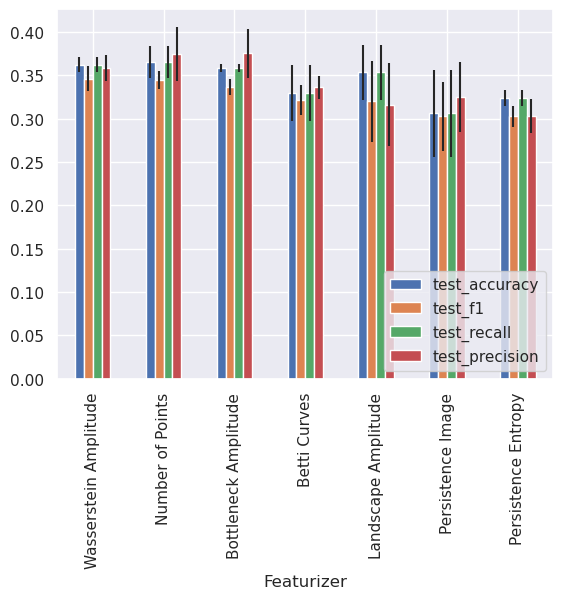

In [24]:
featurizer_models.groupby("Featurizer").mean().sort_values(by=["test_f1"], ascending=False).plot.bar(yerr=featurizer_models.groupby("Featurizer").std())
plt.legend(loc='lower right')

In [25]:
# Print the same for latex
print(featurizer_models.groupby("Featurizer").mean().sort_values(by=["test_accuracy"], ascending=False).to_latex(float_format="{:.2f}".format))

\begin{tabular}{lrrrr}
\toprule
{} &  test\_accuracy &  test\_f1 &  test\_recall &  test\_precision \\
Featurizer            &                &          &              &                 \\
\midrule
Number of Points      &           0.37 &     0.35 &         0.37 &            0.38 \\
Wasserstein Amplitude &           0.36 &     0.35 &         0.36 &            0.36 \\
Bottleneck Amplitude  &           0.36 &     0.34 &         0.36 &            0.38 \\
Landscape Amplitude   &           0.35 &     0.32 &         0.35 &            0.32 \\
Betti Curves          &           0.33 &     0.32 &         0.33 &            0.34 \\
Persistence Entropy   &           0.32 &     0.30 &         0.32 &            0.30 \\
Persistence Image     &           0.31 &     0.30 &         0.31 &            0.32 \\
\bottomrule
\end{tabular}

